# BigData | English Premier League Analysis

## Introducere

Acest proiect își propune să studieze și să analizeze campionatul de fotbal English Premier League (EPL) din Anglia, folosind un set de date ce acoperă meciuri disputate între anii 1993 și ianuarie 2025. Setul de date conține informații detaliate despre fiecare partidă, precum rezultatele finale și la pauză, numărul de goluri marcate, performanțele echipelor, date despre arbitri (inclusiv cartonașe galbene/roșii, faulturi, cornere etc.), dar și alte statistici relevante. Un aspect interesant al proiectului este faptul că sezonul 2024/2025 este în desfășurare (mid-season), ceea ce permite realizarea unor predicții privind clasamentul final pe baza datelor existente până în ianuarie 2025. Analiza va urmări atât performanța echipelor, cât și randamentul arbitrilor, încercând să identifice eventuale favorizări sau pattern-uri interesante, dar și alte idei ce pot reieși din explorarea datelor.

### a. Prezentarea succintă a setului de date

Setul de date utilizat conține, pentru fiecare meci din EPL, următoarele informații principale:

- Data și sezonul meciului
- Echipa gazdă și echipa oaspete
- Numărul de goluri marcate de fiecare echipă (final și la pauză)
- Rezultatul final și la pauză
- Numele arbitrului
- Statistici detaliate: șuturi, șuturi pe poartă, faulturi, cornere, cartonașe galbene și roșii, etc.
- Cote de pariuri și alte metadate

Exemplu de structură a datelor (coloane):

```
MatchID,Season,MatchWeek,Date,Time,HomeTeam,AwayTeam,FullTimeHomeTeamGoals,FullTimeAwayTeamGoals,FullTimeResult,HalfTimeHomeTeamGoals,HalfTimeAwayTeamGoals,HalfTimeResult,Referee,HomeTeamShots,AwayTeamShots,HomeTeamShotsOnTarget,AwayTeamShotsOnTarget,HomeTeamCorners,AwayTeamCorners,HomeTeamFouls,AwayTeamFouls,HomeTeamYellowCards,AwayTeamYellowCards,HomeTeamRedCards,AwayTeamRedCards,B365HomeTeam,B365Draw,B365AwayTeam,B365Over2.5Goals,B365Under2.5Goals,MarketMaxHomeTeam,MarketMaxDraw,MarketMaxAwayTeam,MarketAvgHomeTeam,MarketAvgDraw,MarketAvgAwayTeam,MarketMaxOver2.5Goals,MarketMaxUnder2.5Goals,MarketAvgOver2.5Goals,MarketAvgUnder2.5Goals,HomeTeamPoints,AwayTeamPoints
```

Datele provin din surse publice și pot fi accesate la următorul link: [Premier League Data](https://www.kaggle.com/datasets/ajaxianazarenka/premier-league?resource=download)

### b. Enunțarea obiectivelor

Obiectivele principale ale proiectului sunt:

1. Analiza performanței echipelor și a evoluției acestora de-a lungul sezoanelor EPL.
2. Studiul numărului de goluri marcate, identificarea tendințelor și a factorilor care influențează rezultatele.
3. Analiza randamentului arbitrilor: distribuția cartonașelor, faulturilor și identificarea eventualelor favorizări ale unor echipe de către anumiți arbitri.
4. Realizarea unor vizualizări relevante pentru a evidenția pattern-uri și corelații în date.
5. Deoarece sezonul 2024/2025 este în desfășurare (mid-season), se va încerca realizarea unei predicții a clasamentului final pe baza datelor existente până în ianuarie 2025.
6. Explorarea altor idei interesante care pot reieși din date, precum factori de influență asupra rezultatelor, performanța acasă vs. deplasare, etc.

Un alt scop principal al studiului este de a vedea si corelatia intre inceputul ciclului de victorii a echipei Manchester City si inceputul crizei a echipei Manchester United (ele fiind echipe din acelasi oras).

Proiectul va fi dezvoltat în notebook-ul `EPL_Analysis.ipynb`, folosind instrumente moderne de analiză a datelor și machine learning.


## 1. SPARK

### a. Inițializarea Spark și încărcarea datelor

În această etapă, inițializăm o sesiune Spark și încărcăm setul de date EPL într-un DataFrame Spark pentru a putea lucra cu volume mari de date.


In [1]:
import builtins
from pyspark.sql import SparkSession

# Inițializăm sesiunea Spark
spark = SparkSession.builder.appName("EPL Analysis").getOrCreate()

# Încărcăm datele EPL într-un DataFrame Spark
df = spark.read.option("header", True).option(
    "inferSchema", True).csv("../data/PremierLeague_mid_season.csv")

# Afișăm primele 5 rânduri pentru a verifica încărcarea corectă a datelor
df.show(5)

+--------------------+---------+---------+----------+----+-----------+--------------+---------------------+---------------------+--------------+---------------------+---------------------+--------------+-------+-------------+-------------+---------------------+---------------------+---------------+---------------+-------------+-------------+-------------------+-------------------+----------------+----------------+------------+--------+------------+----------------+-----------------+-----------------+-------------+-----------------+-----------------+-------------+-----------------+---------------------+----------------------+---------------------+----------------------+--------------+--------------+
|             MatchID|   Season|MatchWeek|      Date|Time|   HomeTeam|      AwayTeam|FullTimeHomeTeamGoals|FullTimeAwayTeamGoals|FullTimeResult|HalfTimeHomeTeamGoals|HalfTimeAwayTeamGoals|HalfTimeResult|Referee|HomeTeamShots|AwayTeamShots|HomeTeamShotsOnTarget|AwayTeamShotsOnTarget|HomeTeamC

## b. Explorarea structurii și a valorilor lipsă

În această secțiune, vom analiza structura setului de date și vom identifica valorile lipsă. Acest lucru ne ajută să înțelegem calitatea datelor și să decidem ce preprocesări sunt necesare înainte de analiză. Vom afișa schema DataFrame-ului și vom calcula numărul de valori lipsă pentru fiecare coloană.


In [2]:
# Afișăm schema DataFrame-ului pentru a vedea tipurile de date și coloanele disponibile
from pyspark.sql.functions import col, sum as spark_sum
df.printSchema()

# Redenumim coloanele care conțin caractere speciale (ex: punctul) cu underscore
for col_name in df.columns:
    if '.' in col_name:
        df = df.withColumnRenamed(col_name, col_name.replace('.', '_'))

# Verificăm noile nume de coloane
print(df.columns)

# Calculăm numărul de valori lipsă (NULL) pentru fiecare coloană

missing_counts = df.select(
    [spark_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_counts.show()

root
 |-- MatchID: string (nullable = true)
 |-- Season: string (nullable = true)
 |-- MatchWeek: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- HomeTeam: string (nullable = true)
 |-- AwayTeam: string (nullable = true)
 |-- FullTimeHomeTeamGoals: integer (nullable = true)
 |-- FullTimeAwayTeamGoals: integer (nullable = true)
 |-- FullTimeResult: string (nullable = true)
 |-- HalfTimeHomeTeamGoals: integer (nullable = true)
 |-- HalfTimeAwayTeamGoals: integer (nullable = true)
 |-- HalfTimeResult: string (nullable = true)
 |-- Referee: string (nullable = true)
 |-- HomeTeamShots: integer (nullable = true)
 |-- AwayTeamShots: integer (nullable = true)
 |-- HomeTeamShotsOnTarget: integer (nullable = true)
 |-- AwayTeamShotsOnTarget: integer (nullable = true)
 |-- HomeTeamCorners: integer (nullable = true)
 |-- AwayTeamCorners: integer (nullable = true)
 |-- HomeTeamFouls: integer (nullable = true)
 |-- AwayTeamFouls: integer (nulla

## c. Separarea datelor pentru analize generale vs. analize detaliate

Pentru a asigura acuratețea analizelor, vom separa datele în două subseturi:

- Un subset pentru statistici generale (clasamente, goluri, puncte), unde folosim toate meciurile disponibile, chiar dacă unele coloane au valori lipsă.
- Un subset pentru analize detaliate (șuturi, cornere, arbitri etc.), unde păstrăm doar meciurile din sezonul 2000-2001 încolo și doar acele rânduri care au date complete pe coloanele relevante.


In [3]:
from pyspark.sql.functions import col

# Definim lista cu numele coloanelor de eliminat
cols_to_drop = [
    "Time",
    "B365HomeTeam", "B365Draw", "B365AwayTeam", "B365Over2_5Goals", "B365Under2_5Goals",
    "MarketMaxHomeTeam", "MarketMaxDraw", "MarketMaxAwayTeam",
    "MarketAvgHomeTeam", "MarketAvgDraw", "MarketAvgAwayTeam",
    "MarketMaxOver2_5Goals", "MarketMaxUnder2_5Goals",
    "MarketAvgOver2_5Goals", "MarketAvgUnder2_5Goals"
]

# Eliminăm coloanele doar dacă există în DataFrame
for col_name in cols_to_drop:
    if col_name in df.columns:
        df = df.drop(col_name)

general_cols = [
    "MatchID", "Season", "MatchWeek", "Date", "HomeTeam", "AwayTeam",
    "FullTimeHomeTeamGoals", "FullTimeAwayTeamGoals", "FullTimeResult",
    "HomeTeamPoints", "AwayTeamPoints"
]

# 1. Subset pentru statistici generale (toate meciurile cu scor și echipe)
df_general = df.select(general_cols).dropna()

# 2. Subset pentru analize detaliate (doar meciuri cu date complete, din 2000-2001 încolo)
relevant_cols = [
    "HomeTeam", "AwayTeam", "FullTimeHomeTeamGoals", "FullTimeAwayTeamGoals", "Date",
    "HalfTimeHomeTeamGoals", "HalfTimeAwayTeamGoals", "HalfTimeResult", "Referee",
    "HomeTeamShots", "AwayTeamShots", "HomeTeamShotsOnTarget", "AwayTeamShotsOnTarget",
    "HomeTeamCorners", "AwayTeamCorners", "HomeTeamFouls", "AwayTeamFouls",
    "HomeTeamYellowCards", "AwayTeamYellowCards", "HomeTeamRedCards", "AwayTeamRedCards"
]
df_detailed = (
    df
    .filter(col("Season") >= "2000-2001")
    .dropna(subset=relevant_cols)
)

# Verificăm câte meciuri avem în fiecare subset
print("Meciuri pentru statistici generale:", df_general.count())
print("Meciuri pentru analize detaliate:", df_detailed.count())
print("--------------------------------")

# Aratam primele 20 de rânduri din fiecare subset
df_general.show(20)
df_detailed.show(20)

Meciuri pentru statistici generale: 12001
Meciuri pentru analize detaliate: 9341
--------------------------------
+--------------------+---------+---------+----------+----------------+----------------+---------------------+---------------------+--------------+--------------+--------------+
|             MatchID|   Season|MatchWeek|      Date|        HomeTeam|        AwayTeam|FullTimeHomeTeamGoals|FullTimeAwayTeamGoals|FullTimeResult|HomeTeamPoints|AwayTeamPoints|
+--------------------+---------+---------+----------+----------------+----------------+---------------------+---------------------+--------------+--------------+--------------+
|1993-1994_Arsenal...|1993-1994|        1|1993-08-14|         Arsenal|        Coventry|                    0|                    3|             A|             0|             3|
|1993-1994_Aston V...|1993-1994|        1|1993-08-14|     Aston Villa|             QPR|                    4|                    1|             H|             3|             0|
|

In [4]:
# Încărcăm datele pentru meciurile viitoare
df_upcoming = spark.read.option("header", True).option(
    "inferSchema", True).csv("../data/PremierLeague_upcoming.csv")

print("=== Meciuri viitoare ===")
print(f"Numărul total de meciuri viitoare: {df_upcoming.count()}")
df_upcoming.show(10)

# Verificăm structura datelor viitoare
print("\n=== Structura datelor viitoare ===")
df_upcoming.printSchema()

=== Meciuri viitoare ===
Numărul total de meciuri viitoare: 159
+--------------------+---------+---------+---------+-------------------+--------------+-------------+---------------------+---------------------+--------------+---------------------+---------------------+--------------+------------+-------------+-------------+---------------------+---------------------+---------------+---------------+-------------+-------------+-------------------+-------------------+----------------+----------------+------------+--------+------------+----------------+-----------------+-----------------+-------------+-----------------+-----------------+-------------+-----------------+---------------------+----------------------+---------------------+----------------------+--------------+--------------+
|             MatchID|   Season|MatchWeek|     Date|               Time|      HomeTeam|     AwayTeam|FullTimeHomeTeamGoals|FullTimeAwayTeamGoals|FullTimeResult|HalfTimeHomeTeamGoals|HalfTimeAwayTeamGoals|Hal

In [5]:
from pyspark.sql.functions import col, count, sum as spark_sum, when, coalesce, lit
from pyspark.sql.types import *
import numpy as np
import builtins  # Pentru a avea acces la funcțiile Python native

# Definim sezoanele recente (ultimele 2 sezoane pentru a fi mai relevant)
recent_seasons = ["2023-2024", "2024-2025"]

# Filtrăm datele pentru sezoanele recente
df_recent = df_general.filter(col("Season").isin(recent_seasons))

print("=== Analiza Formei Recente (Ultimele 2 sezoane) ===")
print(f"Meciuri în sezoanele recente: {df_recent.count()}")

# Calculăm statisticile pentru fiecare echipă în sezoanele recente


def calculate_team_stats(df, team_col_home, team_col_away, team_name):
    """Calculează statisticile pentru o echipă (acasă și deplasare)"""

    # Statistici acasă
    home_stats = df.filter(col(team_col_home) == team_name).agg(
        count("*").alias("home_matches"),
        spark_sum(when(col("FullTimeResult") == "H",
                  1).otherwise(0)).alias("home_wins"),
        spark_sum(when(col("FullTimeResult") == "D",
                  1).otherwise(0)).alias("home_draws"),
        spark_sum(when(col("FullTimeResult") == "A",
                  1).otherwise(0)).alias("home_losses"),
        spark_sum("FullTimeHomeTeamGoals").alias("home_goals_for"),
        spark_sum("FullTimeAwayTeamGoals").alias("home_goals_against"),
        spark_sum("HomeTeamPoints").alias("home_points")
    ).collect()[0]

    # Statistici deplasare
    away_stats = df.filter(col(team_col_away) == team_name).agg(
        count("*").alias("away_matches"),
        spark_sum(when(col("FullTimeResult") == "A",
                  1).otherwise(0)).alias("away_wins"),
        spark_sum(when(col("FullTimeResult") == "D",
                  1).otherwise(0)).alias("away_draws"),
        spark_sum(when(col("FullTimeResult") == "H",
                  1).otherwise(0)).alias("away_losses"),
        spark_sum("FullTimeAwayTeamGoals").alias("away_goals_for"),
        spark_sum("FullTimeHomeTeamGoals").alias("away_goals_against"),
        spark_sum("AwayTeamPoints").alias("away_points")
    ).collect()[0]

    return home_stats, away_stats


# Obținem lista echipelor din sezonul curent folosind collect() direct pe DataFrame
current_season_df = df_recent.filter(
    col("Season") == "2024-2025").select("HomeTeam").distinct()
current_season_teams = [row.HomeTeam for row in current_season_df.collect()]

print(f"Echipe în sezonul curent: {len(current_season_teams)}")
print("Echipele:", sorted(current_season_teams))

=== Analiza Formei Recente (Ultimele 2 sezoane) ===
Meciuri în sezoanele recente: 601
Echipe în sezonul curent: 20
Echipele: ['Arsenal', 'Aston Villa', 'Bournemouth', 'Brentford', 'Brighton', 'Chelsea', 'Crystal Palace', 'Everton', 'Fulham', 'Ipswich', 'Leicester', 'Liverpool', 'Man City', 'Man United', 'Newcastle', "Nott'm Forest", 'Southampton', 'Tottenham', 'West Ham', 'Wolves']


In [6]:
# Calculăm statisticile complete pentru fiecare echipă
team_performance = {}

for team in current_season_teams:
    home_stats, away_stats = calculate_team_stats(
        df_recent, "HomeTeam", "AwayTeam", team)

    # Combinăm statisticile
    total_matches = home_stats.home_matches + away_stats.away_matches
    total_wins = home_stats.home_wins + away_stats.away_wins
    total_draws = home_stats.home_draws + away_stats.away_draws
    total_losses = home_stats.home_losses + away_stats.away_losses
    total_goals_for = home_stats.home_goals_for + away_stats.away_goals_for
    total_goals_against = home_stats.home_goals_against + away_stats.away_goals_against
    total_points = home_stats.home_points + away_stats.away_points

    # Calculăm ratele și indicatorii
    win_rate = total_wins / total_matches if total_matches > 0 else 0
    points_per_game = total_points / total_matches if total_matches > 0 else 0
    goals_per_game = total_goals_for / total_matches if total_matches > 0 else 0
    goals_against_per_game = total_goals_against / \
        total_matches if total_matches > 0 else 0
    goal_difference = total_goals_for - total_goals_against

    # Avantajul terenului propriu
    home_win_rate = home_stats.home_wins / \
        home_stats.home_matches if home_stats.home_matches > 0 else 0
    away_win_rate = away_stats.away_wins / \
        away_stats.away_matches if away_stats.away_matches > 0 else 0
    home_advantage = home_win_rate - away_win_rate

    # Factor de risc (variabilitatea - calculat simplu ca diferența între home și away performance)
    home_ppg = home_stats.home_points / \
        home_stats.home_matches if home_stats.home_matches > 0 else 0
    away_ppg = away_stats.away_points / \
        away_stats.away_matches if away_stats.away_matches > 0 else 0
    # Folosim __builtin__.abs pentru a evita conflictul cu pyspark.sql.functions.abs
    import builtins
    # Cât de inconsistentă este echipa
    risk_factor = builtins.abs(home_ppg - away_ppg)

    team_performance[team] = {
        'total_matches': total_matches,
        'win_rate': win_rate,
        'points_per_game': points_per_game,
        'goals_per_game': goals_per_game,
        'goals_against_per_game': goals_against_per_game,
        'goal_difference': goal_difference,
        'home_advantage': home_advantage,
        'risk_factor': risk_factor,
        'home_win_rate': home_win_rate,
        'away_win_rate': away_win_rate,
        'home_ppg': home_ppg,
        'away_ppg': away_ppg
    }

# Afișăm statisticile pentru primele 10 echipe
print("\n=== Statistici Echipe (Ultimele 2 sezoane) ===")
sorted_teams = sorted(team_performance.items(),
                      key=lambda x: x[1]['points_per_game'], reverse=True)

for i, (team, stats) in enumerate(sorted_teams[:10]):
    print(f"{i+1:2d}. {team:15s} | PPG: {stats['points_per_game']:.2f} | Win%: {stats['win_rate']:.1%} | "
          f"Home Adv: {stats['home_advantage']:+.2f} | Risk: {stats['risk_factor']:.2f}")


=== Statistici Echipe (Ultimele 2 sezoane) ===
 1. Liverpool       | PPG: 2.24 | Win%: 66.1% | Home Adv: +0.19 | Risk: 0.41
 2. Arsenal         | PPG: 2.22 | Win%: 66.7% | Home Adv: +0.13 | Risk: 0.37
 3. Man City        | PPG: 2.16 | Win%: 65.6% | Home Adv: +0.09 | Risk: 0.33
 4. Chelsea         | PPG: 1.74 | Win%: 49.2% | Home Adv: +0.12 | Risk: 0.34
 5. Aston Villa     | PPG: 1.73 | Win%: 50.0% | Home Adv: +0.20 | Risk: 0.67
 6. Newcastle       | PPG: 1.63 | Win%: 48.3% | Home Adv: +0.23 | Risk: 0.73
 7. Tottenham       | PPG: 1.50 | Win%: 45.0% | Home Adv: +0.23 | Risk: 0.53
 8. Man United      | PPG: 1.43 | Win%: 41.7% | Home Adv: +0.14 | Risk: 0.30
 9. Bournemouth     | PPG: 1.42 | Win%: 38.3% | Home Adv: +0.06 | Risk: 0.26
10. Brighton        | PPG: 1.37 | Win%: 33.3% | Home Adv: +0.09 | Risk: 0.36


In [7]:
# Calculăm punctele actuale pentru sezonul 2024-2025 (până la matchweek 22)
current_season_data = df_recent.filter(
    (col("Season") == "2024-2025") &
    (col("MatchWeek") <= 22)
)

print("=== Puncte Actuale Sezonul 2024-2025 (MW 1-22) ===")
print(f"Meciuri jucate până acum: {current_season_data.count()}")

# Calculăm punctele pentru fiecare echipă în sezonul curent
current_points = {}

for team in current_season_teams:
    # Puncte acasă
    home_points = current_season_data.filter(col("HomeTeam") == team).agg(
        spark_sum("HomeTeamPoints").alias("points")
    ).collect()[0].points or 0

    # Puncte deplasare
    away_points = current_season_data.filter(col("AwayTeam") == team).agg(
        spark_sum("AwayTeamPoints").alias("points")
    ).collect()[0].points or 0

    # Meciuri jucate
    home_matches = current_season_data.filter(col("HomeTeam") == team).count()
    away_matches = current_season_data.filter(col("AwayTeam") == team).count()

    total_points = home_points + away_points
    total_matches = home_matches + away_matches

    current_points[team] = {
        'points': total_points,
        'matches_played': total_matches,
        'home_points': home_points,
        'away_points': away_points
    }

# Sortăm echipele după puncte
current_table = sorted(current_points.items(),
                       key=lambda x: x[1]['points'], reverse=True)

print("\n=== Clasamentul Actual (după MW 22) ===")
print("Pos | Echipa           | Puncte | Meciuri | PPG")
print("-" * 50)

for i, (team, stats) in enumerate(current_table):
    ppg = stats['points'] / \
        stats['matches_played'] if stats['matches_played'] > 0 else 0
    print(
        f"{i+1:2d}  | {team:15s} | {stats['points']:6d} | {stats['matches_played']:7d} | {ppg:.2f}")

# Salvăm clasamentul actual pentru vizualizare
current_standings = {team: stats['points'] for team, stats in current_table}

=== Puncte Actuale Sezonul 2024-2025 (MW 1-22) ===
Meciuri jucate până acum: 219

=== Clasamentul Actual (după MW 22) ===
Pos | Echipa           | Puncte | Meciuri | PPG
--------------------------------------------------
 1  | Liverpool       |     50 |      21 | 2.38
 2  | Nott'm Forest   |     44 |      22 | 2.00
 3  | Arsenal         |     44 |      22 | 2.00
 4  | Chelsea         |     40 |      22 | 1.82
 5  | Man City        |     38 |      22 | 1.73
 6  | Newcastle       |     38 |      22 | 1.73
 7  | Bournemouth     |     37 |      22 | 1.68
 8  | Aston Villa     |     36 |      22 | 1.64
 9  | Brighton        |     34 |      22 | 1.55
10  | Fulham          |     33 |      22 | 1.50
11  | Brentford       |     28 |      22 | 1.27
12  | Crystal Palace  |     27 |      22 | 1.23
13  | West Ham        |     26 |      22 | 1.18
14  | Man United      |     26 |      22 | 1.18
15  | Tottenham       |     24 |      22 | 1.09
16  | Everton         |     20 |      21 | 0.95
17  | Wolve

In [8]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
import random
import builtins  # Pentru funcțiile Python native


def predict_match_result(home_team, away_team, team_performance, is_home_advantage=True):
    """
    Prezice rezultatul unui meci bazat pe statisticile echipelor
    Returnează probabilitățile pentru H, D, A
    """

    home_stats = team_performance.get(home_team, {})
    away_stats = team_performance.get(away_team, {})

    # Factori de bază
    home_strength = home_stats.get('points_per_game', 1.0)
    away_strength = away_stats.get('points_per_game', 1.0)

    # Avantajul terenului propriu
    home_advantage_factor = home_stats.get(
        'home_advantage', 0.0) if is_home_advantage else 0.0

    # Factor de risc (inconsistența)
    home_risk = home_stats.get('risk_factor', 0.5)
    away_risk = away_stats.get('risk_factor', 0.5)

    # Calculăm probabilitățile de bază
    strength_diff = home_strength - away_strength + home_advantage_factor

    # Normalizăm diferența de forță
    if strength_diff > 1.0:
        home_prob = 0.6 + builtins.min(0.25, strength_diff * 0.1)
    elif strength_diff > 0.3:
        home_prob = 0.5 + strength_diff * 0.2
    elif strength_diff > -0.3:
        home_prob = 0.4 + strength_diff * 0.15
    elif strength_diff > -1.0:
        home_prob = 0.3 + strength_diff * 0.1
    else:
        home_prob = 0.15 + builtins.max(-0.1, strength_diff * 0.05)

    # Calculăm probabilitatea de egalitate (mai mare când echipele sunt echilibrate)
    draw_base = 0.25
    balance_factor = 1 - builtins.abs(strength_diff)
    draw_prob = draw_base + balance_factor * 0.1

    # Probabilitatea pentru echipa oaspete
    away_prob = 1.0 - home_prob - draw_prob

    # Ajustăm pentru factorul de risc (echipele inconsistente au rezultate mai imprevizibile)
    risk_adjustment = (home_risk + away_risk) * 0.05
    draw_prob += risk_adjustment
    home_prob -= risk_adjustment / 2
    away_prob -= risk_adjustment / 2

    # Normalizăm să fie sigur că suma = 1
    total = home_prob + draw_prob + away_prob
    home_prob /= total
    draw_prob /= total
    away_prob /= total

    return home_prob, draw_prob, away_prob


def simulate_match_points(home_prob, draw_prob, away_prob):
    """Simulează rezultatul unui meci și returnează punctele pentru fiecare echipă"""
    rand = random.random()

    if rand < home_prob:
        return 3, 0  # Victoria gazdelor
    elif rand < home_prob + draw_prob:
        return 1, 1  # Egalitate
    else:
        return 0, 3  # Victoria oaspeților


# Testăm modelul pe câteva meciuri
print("=== Test Model de Predicție ===")
test_matches = [
    ("Liverpool", "Arsenal"),
    ("Man City", "Chelsea"),
    ("Man United", "Tottenham"),
    ("Brighton", "Aston Villa")
]

for home, away in test_matches:
    h_prob, d_prob, a_prob = predict_match_result(home, away, team_performance)
    print(f"{home:12s} vs {away:12s} | H: {h_prob:.1%} D: {d_prob:.1%} A: {a_prob:.1%}")

print("\n=== Factori de Predicție ===")
print("- Forma recentă (PPG ultimele 2 sezoane)")
print("- Avantajul terenului propriu")
print("- Factorul de risc (inconsistența)")
print("- Echilibrarea probabilităților")

=== Test Model de Predicție ===
Liverpool    vs Arsenal      | H: 41.2% D: 36.8% A: 22.0%
Man City     vs Chelsea      | H: 58.6% D: 33.2% A: 8.2%
Man United   vs Tottenham    | H: 39.0% D: 38.5% A: 22.5%
Brighton     vs Aston Villa  | H: 33.3% D: 37.3% A: 29.4%

=== Factori de Predicție ===
- Forma recentă (PPG ultimele 2 sezoane)
- Avantajul terenului propriu
- Factorul de risc (inconsistența)
- Echilibrarea probabilităților


In [9]:
# Obținem lista meciurilor viitoare
upcoming_matches = df_upcoming.select(
    "MatchWeek", "HomeTeam", "AwayTeam").collect()

print(f"=== Simularea a {len(upcoming_matches)} Meciuri Viitoare ===")

# Inițializăm punctele finale cu punctele actuale
final_points = current_standings.copy()
match_predictions = []

# Simulăm fiecare meci
random.seed(42)  # Pentru reproducibilitate

for match in upcoming_matches:
    matchweek = match.MatchWeek
    home_team = match.HomeTeam
    away_team = match.AwayTeam

    # Prezice rezultatul
    h_prob, d_prob, a_prob = predict_match_result(
        home_team, away_team, team_performance)

    # Simulează punctele
    home_points, away_points = simulate_match_points(h_prob, d_prob, a_prob)

    # Actualizează punctele finale
    if home_team in final_points:
        final_points[home_team] += home_points
    if away_team in final_points:
        final_points[away_team] += away_points

    # Salvează predicția
    match_predictions.append({
        'matchweek': matchweek,
        'home_team': home_team,
        'away_team': away_team,
        'home_prob': h_prob,
        'draw_prob': d_prob,
        'away_prob': a_prob,
        'predicted_home_points': home_points,
        'predicted_away_points': away_points
    })

# Sortăm clasamentul final
final_table = sorted(final_points.items(), key=lambda x: x[1], reverse=True)

print("\n=== Clasamentul Final Proiectat ===")
print("Pos | Echipa           | Puncte | +/- vs Actual")
print("-" * 55)

for i, (team, points) in enumerate(final_table):
    current_pts = current_standings.get(team, 0)
    predicted_gain = points - current_pts
    print(f"{i+1:2d}  | {team:15s} | {points:6d} | {predicted_gain:+4d}")

print(f"\nTotal meciuri simulate: {len(match_predictions)}")
print(
    f"Puncte distribuite: {builtins.sum(pred['predicted_home_points'] + pred['predicted_away_points'] for pred in match_predictions)}")

# Calculăm câteva statistici interesante
home_wins = builtins.sum(
    1 for pred in match_predictions if pred['predicted_home_points'] == 3)
draws = builtins.sum(
    1 for pred in match_predictions if pred['predicted_home_points'] == 1)
away_wins = builtins.sum(
    1 for pred in match_predictions if pred['predicted_away_points'] == 3)

print(f"\nDistribuția rezultatelor prezise:")
print(f"Victorii gazde: {home_wins} ({home_wins/len(match_predictions):.1%})")
print(f"Egalități: {draws} ({draws/len(match_predictions):.1%})")
print(
    f"Victorii oaspeți: {away_wins} ({away_wins/len(match_predictions):.1%})")

=== Simularea a 159 Meciuri Viitoare ===

=== Clasamentul Final Proiectat ===
Pos | Echipa           | Puncte | +/- vs Actual
-------------------------------------------------------
 1  | Liverpool       |     92 |  +42
 2  | Arsenal         |     83 |  +39
 3  | Nott'm Forest   |     71 |  +27
 4  | Man City        |     69 |  +31
 5  | Chelsea         |     65 |  +25
 6  | Aston Villa     |     62 |  +26
 7  | Newcastle       |     60 |  +22
 8  | Bournemouth     |     57 |  +20
 9  | Brighton        |     57 |  +23
10  | Fulham          |     56 |  +23
11  | West Ham        |     51 |  +25
12  | Brentford       |     50 |  +22
13  | Man United      |     46 |  +20
14  | Crystal Palace  |     41 |  +14
15  | Tottenham       |     39 |  +15
16  | Everton         |     37 |  +17
17  | Wolves          |     30 |  +14
18  | Ipswich         |     24 |   +8
19  | Leicester       |     22 |   +8
20  | Southampton     |     13 |   +7

Total meciuri simulate: 159
Puncte distribuite: 428

Dist

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Calculăm evoluția punctelor pentru fiecare matchweek


def calculate_points_evolution():
    """Calculează punctele cumulative pentru fiecare echipă la fiecare matchweek"""

    # Punctele reale până la MW 22
    points_evolution = defaultdict(lambda: defaultdict(int))

    # Inițializăm cu 0 puncte pentru toate echipele
    for team in current_season_teams:
        for mw in range(1, 39):  # MW 1-38
            points_evolution[team][mw] = 0

    # Calculăm punctele reale pentru MW 1-22
    matches_played = current_season_data.select("MatchWeek", "HomeTeam", "AwayTeam",
                                                "HomeTeamPoints", "AwayTeamPoints").collect()

    # Sortăm meciurile după matchweek
    matches_played = sorted(matches_played, key=lambda x: x.MatchWeek)

    # Calculăm punctele cumulative pentru meciurile jucate
    team_cumulative = {team: 0 for team in current_season_teams}

    for match in matches_played:
        mw = match.MatchWeek
        home_team = match.HomeTeam
        away_team = match.AwayTeam
        home_points = match.HomeTeamPoints or 0
        away_points = match.AwayTeamPoints or 0

        # Actualizăm punctele cumulative
        team_cumulative[home_team] += home_points
        team_cumulative[away_team] += away_points

        # Salvăm punctele pentru acest matchweek
        for team in current_season_teams:
            points_evolution[team][mw] = team_cumulative[team]

    # Completăm punctele pentru MW 23-38 cu predicțiile
    # Sortăm predicțiile după matchweek
    predictions_by_mw = defaultdict(list)
    for pred in match_predictions:
        predictions_by_mw[pred['matchweek']].append(pred)

    # Aplicăm predicțiile pentru fiecare matchweek
    for mw in range(23, 39):
        if mw in predictions_by_mw:
            for pred in predictions_by_mw[mw]:
                home_team = pred['home_team']
                away_team = pred['away_team']
                home_points = pred['predicted_home_points']
                away_points = pred['predicted_away_points']

                # Actualizăm punctele cumulative
                if home_team in team_cumulative:
                    team_cumulative[home_team] += home_points
                if away_team in team_cumulative:
                    team_cumulative[away_team] += away_points

        # Salvăm punctele pentru acest matchweek
        for team in current_season_teams:
            points_evolution[team][mw] = team_cumulative[team]

    return points_evolution


# Calculăm evoluția punctelor
points_evolution = calculate_points_evolution()

print("=== Evoluția Punctelor Calculată ===")
print("Puncte după MW 22 (reale) și MW 38 (prezise):")

for i, (team, _) in enumerate(final_table[:10]):
    mw22_points = points_evolution[team][22]
    mw38_points = points_evolution[team][38]
    print(f"{team:15s}: MW22={mw22_points:2d} → MW38={mw38_points:2d} (+{mw38_points-mw22_points:2d})")

=== Evoluția Punctelor Calculată ===
Puncte după MW 22 (reale) și MW 38 (prezise):
Liverpool      : MW22=50 → MW38=89 (+39)
Arsenal        : MW22=44 → MW38=83 (+39)
Nott'm Forest  : MW22=44 → MW38=71 (+27)
Man City       : MW22=38 → MW38=69 (+31)
Chelsea        : MW22=40 → MW38=65 (+25)
Aston Villa    : MW22=36 → MW38=62 (+26)
Newcastle      : MW22=38 → MW38=60 (+22)
Bournemouth    : MW22=37 → MW38=57 (+20)
Brighton       : MW22=34 → MW38=57 (+23)
Fulham         : MW22=33 → MW38=56 (+23)


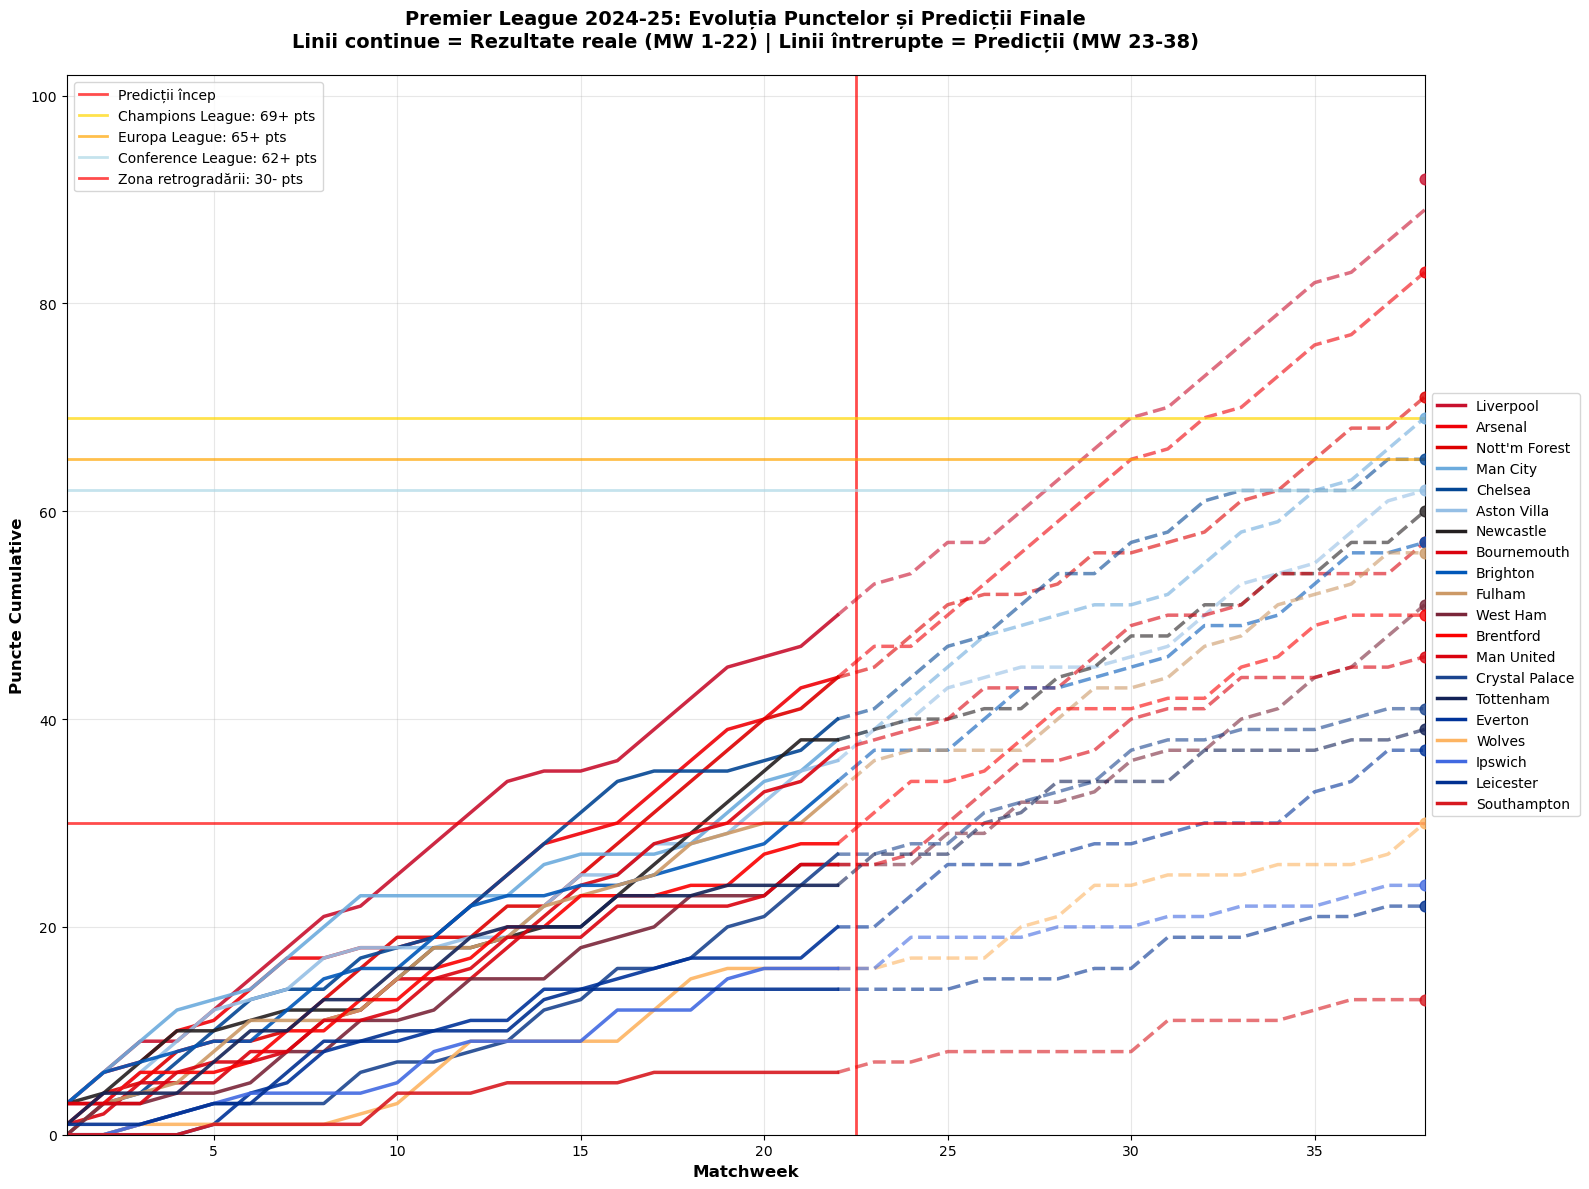


CLASAMENTUL FINAL PROIECTAT CU ZONELE DE CALIFICARE
 1. Liverpool        92 pts (+42) | 🏆 Campioni
 2. Arsenal          83 pts (+39) | 🏆 Calificare Champions League
 3. Nott'm Forest    71 pts (+27) | 🏆 Calificare Champions League
 4. Man City         69 pts (+31) | 🏆 Calificare Champions League
 5. Chelsea          65 pts (+25) | 🏆 Calificare Champions League
 6. Aston Villa      62 pts (+26) | 🥈 Europa League
 7. Newcastle        60 pts (+22) | 🥉 Conference League
 8. Bournemouth      57 pts (+20) |    Mid-table
 9. Brighton         57 pts (+23) |    Mid-table
10. Fulham           56 pts (+23) |    Mid-table
11. West Ham         51 pts (+25) |    Mid-table
12. Brentford        50 pts (+22) |    Mid-table
13. Man United       46 pts (+20) |    Mid-table
14. Crystal Palace   41 pts (+14) |    Mid-table
15. Tottenham        39 pts (+15) |    Mid-table
16. Everton          37 pts (+17) |    Mid-table
17. Wolves           30 pts (+14) |    Mid-table
18. Ipswich          24 pts (+ 8) | ⬇️

In [18]:
# Creăm vizualizarea principală
plt.style.use('default')
fig, ax = plt.subplots(figsize=(16, 12))

# Definim culorile pentru echipe (top 6 + altele)
team_colors = {
    'Liverpool': '#C8102E',
    'Arsenal': '#EF0107',
    'Chelsea': '#034694',
    'Man City': '#6CABDD',
    'Man United': '#DA020E',
    'Tottenham': '#132257',
    'Aston Villa': '#95BFE5',
    'Brighton': '#0057B8',
    'Newcastle': '#241F20',
    'Fulham': '#CC9966',
    'Bournemouth': '#DA020E',
    'Nott\'m Forest': '#DD0000',
    'Brentford': '#FB0000',
    'West Ham': '#7A263A',
    'Crystal Palace': '#1B458F',
    'Everton': '#003399',
    'Leicester': '#003090',
    'Wolves': '#FDB462',
    'Ipswich': '#4169E1',
    'Southampton': '#D71920'
}

# Matchweeks (1-38)
matchweeks = list(range(1, 39))

# Plotăm liniile pentru fiecare echipă
for i, (team, final_pts) in enumerate(final_table):
    points_by_mw = [points_evolution[team][mw] for mw in matchweeks]

    color = team_colors.get(team, '#808080')

    # Linia reală (MW 1-22)
    real_mw = matchweeks[:22]
    real_points = points_by_mw[:22]
    ax.plot(real_mw, real_points, color=color,
            linewidth=2.5, alpha=0.9, label=team)

    # Linia prezisă (MW 23-38)
    pred_mw = matchweeks[21:]  # De la MW 22 la MW 38
    pred_points = points_by_mw[21:]
    ax.plot(pred_mw, pred_points, color=color,
            linewidth=2.5, alpha=0.6, linestyle='--')

    # Punctul final
    ax.scatter(38, final_pts, color=color, s=60, alpha=0.8, zorder=5)

# Linia verticală care separă realul de predicții
ax.axvline(x=22.5, color='red', linestyle='-', alpha=0.7,
           linewidth=2, label='Predicții încep')

# Zonele de calificare (linii orizontale)
# Estimăm punctele necesare bazat pe clasamentul final
final_points_sorted = [pts for _, pts in final_table]

# Champions League (Top 4)
cl_threshold = final_points_sorted[3] if len(final_points_sorted) > 3 else 70
ax.axhline(y=cl_threshold, color='gold', linestyle='-', alpha=0.7, linewidth=2,
           label=f'Champions League (Top 4): {cl_threshold} pts')

# Europa League (5th place)
el_threshold = final_points_sorted[4] if len(final_points_sorted) > 4 else 65
ax.axhline(y=el_threshold, color='orange', linestyle='-', alpha=0.7, linewidth=2,
           label=f'Europa League (5th): {el_threshold} pts')

# Conference League (6th place)
conf_threshold = final_points_sorted[5] if len(final_points_sorted) > 5 else 60
ax.axhline(y=conf_threshold, color='lightblue', linestyle='-', alpha=0.7, linewidth=2,
           label=f'Conference League (6th): {conf_threshold} pts')

# Retrogradare (Bottom 3)
rel_threshold = final_points_sorted[-4] if len(final_points_sorted) > 3 else 35
ax.axhline(y=rel_threshold, color='red', linestyle='-', alpha=0.7, linewidth=2,
           label=f'Retrogradare (Bottom 3): {rel_threshold} pts')

# Formatarea graficului
ax.set_xlabel('Matchweek', fontsize=12, fontweight='bold')
ax.set_ylabel('Puncte Cumulative', fontsize=12, fontweight='bold')
ax.set_title('Premier League 2024-25: Evoluția Punctelor și Predicții Finale\n' +
             'Linii continue = Rezultate reale (MW 1-22) | Linii întrerupte = Predicții (MW 23-38)',
             fontsize=14, fontweight='bold', pad=20)

# Setăm limitele axelor
ax.set_xlim(1, 38)
ax.set_ylim(0, builtins.max(final_points_sorted) + 10)

# Grid
ax.grid(True, alpha=0.3)

# Legendă pentru zonele de calificare (separată)
legend1 = ax.legend(handles=[
    plt.Line2D([0], [0], color='red', linestyle='-', alpha=0.7,
               linewidth=2, label='Predicții încep'),
    plt.Line2D([0], [0], color='gold', linestyle='-', alpha=0.7,
               linewidth=2, label=f'Champions League: {cl_threshold}+ pts'),
    plt.Line2D([0], [0], color='orange', linestyle='-', alpha=0.7,
               linewidth=2, label=f'Europa League: {el_threshold}+ pts'),
    plt.Line2D([0], [0], color='lightblue', linestyle='-', alpha=0.7,
               linewidth=2, label=f'Conference League: {conf_threshold}+ pts'),
    plt.Line2D([0], [0], color='red', linestyle='-', alpha=0.7,
               linewidth=2, label=f'Zona retrogradării: {rel_threshold}- pts')
], loc='upper left', fontsize=10)

ax.add_artist(legend1)

# Legendă pentru echipe (doar top 20)
team_handles = []
for team, _ in final_table[:20]:
    color = team_colors.get(team, '#808080')
    team_handles.append(plt.Line2D(
        [0], [0], color=color, linewidth=2.5, label=team))

ax.legend(handles=team_handles, loc='center left',
          bbox_to_anchor=(1, 0.5), fontsize=10)

plt.tight_layout()
plt.show()

# Afișăm și clasamentul final cu zonele
print("\n" + "="*60)
print("CLASAMENTUL FINAL PROIECTAT CU ZONELE DE CALIFICARE")
print("="*60)

# 1. Champions
# 2. 3. 4. 5. Chmapions League Qualification
# 6. Europa League
# 7. Conference League
# 18. 19. 20. Retrogradare

zones = []
for i, (team, points) in enumerate(final_table):
    if i == 0:
        zone = "🏆 Campioni"
    elif i == 1 or i == 2 or i == 3 or i == 4:
        zone = "🏆 Calificare Champions League"
    elif i == 5:
        zone = "🥈 Europa League"
    elif i == 6:
        zone = "🥉 Conference League"
    elif i >= len(final_table) - 3:
        zone = "⬇️  Retrogradare"
    else:
        zone = "   Mid-table"
    zones.append((i+1, team, points, zone))

for pos, team, points, zone in zones:
    current_pts = current_standings.get(team, 0)
    gain = points - current_pts
    print(f"{pos:2d}. {team:15s} {points:3d} pts (+{gain:2d}) | {zone}")

print("\n" + "="*60)

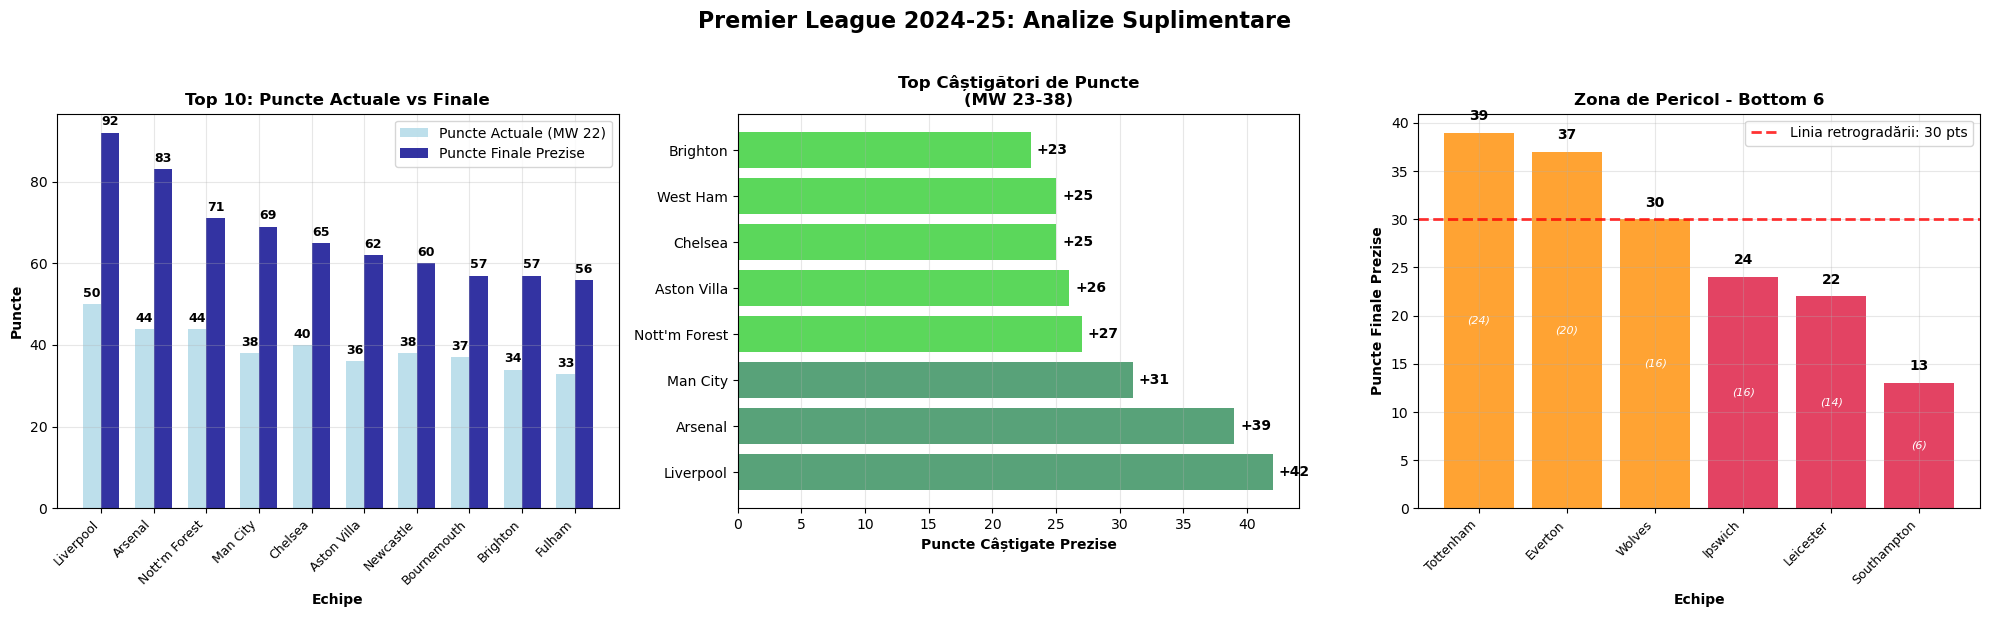


STATISTICI FINALE DESPRE PREDICȚII

Cel mai mare câștig prezis: Liverpool (+42 puncte)
Cea mai mică creștere prezisă: Southampton (+7 puncte)

Echipe în zona retrogradării: Ipswich, Leicester, Southampton
Echipe în Champions League: Liverpool, Arsenal, Nott'm Forest, Man City

Total puncte de câștigat: 428
Total puncte disponibile: 480
Eficiența prezisă: 89.2%


In [21]:
# Grafice suplimentare frumoase pentru analiză

# Creăm 3 grafice elegante
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Premier League 2024-25: Analize Suplimentare',
             fontsize=16, fontweight='bold', y=1.02)

# Grafic 1: Top 10 echipe - Puncte actuale vs Puncte finale prezise
top_10_teams = final_table[:10]
teams_top10 = [team for team, _ in top_10_teams]
current_pts_top10 = [current_standings.get(team, 0) for team in teams_top10]
final_pts_top10 = [pts for _, pts in top_10_teams]

x_pos = range(len(teams_top10))
width = 0.35

bars1 = ax1.bar([x - width/2 for x in x_pos], current_pts_top10, width,
                label='Puncte Actuale (MW 22)', color='lightblue', alpha=0.8)
bars2 = ax1.bar([x + width/2 for x in x_pos], final_pts_top10, width,
                label='Puncte Finale Prezise', color='darkblue', alpha=0.8)

# Adăugăm valorile pe bare
for i, (current, final) in enumerate(zip(current_pts_top10, final_pts_top10)):
    ax1.text(i - width/2, current + 1, str(current), ha='center',
             va='bottom', fontweight='bold', fontsize=9)
    ax1.text(i + width/2, final + 1, str(final), ha='center',
             va='bottom', fontweight='bold', fontsize=9)

ax1.set_xlabel('Echipe', fontweight='bold')
ax1.set_ylabel('Puncte', fontweight='bold')
ax1.set_title('Top 10: Puncte Actuale vs Finale', fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(teams_top10, rotation=45, ha='right', fontsize=9)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Grafic 2: Câștigul de puncte prezis pentru fiecare echipă (Top 8)
all_teams = [team for team, _ in final_table]
all_gains = [final_table[i][1] -
             current_standings.get(final_table[i][0], 0) for i in range(len(final_table))]

# Sortăm după câștigul de puncte
team_gains = list(zip(all_teams, all_gains))
team_gains.sort(key=lambda x: x[1], reverse=True)

top_gainers = team_gains[:8]  # Top 8 câștigători
teams_gain = [team for team, _ in top_gainers]
gains = [gain for _, gain in top_gainers]

colors_gain = ['#2E8B57' if g > 30 else '#32CD32' if g >
               20 else '#FFD700' for g in gains]
bars2 = ax2.barh(teams_gain, gains, color=colors_gain, alpha=0.8)

# Adăugăm valorile pe bare
for i, gain in enumerate(gains):
    ax2.text(gain + 0.5, i, f'+{gain}', va='center',
             ha='left', fontweight='bold')

ax2.set_xlabel('Puncte Câștigate Prezise', fontweight='bold')
ax2.set_title('Top Câștigători de Puncte\n(MW 23-38)', fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# Grafic 3: Zona de pericol - Bottom 6 echipe
bottom_6_teams = final_table[-6:]
teams_bottom = [team for team, _ in bottom_6_teams]
final_pts_bottom = [pts for _, pts in bottom_6_teams]
current_pts_bottom = [current_standings.get(team, 0) for team in teams_bottom]

# Colorăm în funcție de zona de retrogradare
colors_bottom = []
for i, (team, pts) in enumerate(bottom_6_teams):
    if i >= 3:  # Bottom 3 = retrogradare
        colors_bottom.append('#DC143C')  # Roșu
    else:
        colors_bottom.append('#FF8C00')  # Portocaliu

bars3 = ax3.bar(range(len(teams_bottom)), final_pts_bottom,
                color=colors_bottom, alpha=0.8)

# Linia de retrogradare
relegation_line = final_table[-4][1] if len(final_table) > 3 else 35
ax3.axhline(y=relegation_line, color='red', linestyle='--', alpha=0.8, linewidth=2,
            label=f'Linia retrogradării: {relegation_line} pts')

# Adăugăm valorile pe bare
for i, (pts, current) in enumerate(zip(final_pts_bottom, current_pts_bottom)):
    ax3.text(i, pts + 1, str(pts), ha='center', va='bottom', fontweight='bold')
    ax3.text(i, pts/2, f'({current})', ha='center', va='center',
             fontsize=8, style='italic', color='white')

ax3.set_xlabel('Echipe', fontweight='bold')
ax3.set_ylabel('Puncte Finale Prezise', fontweight='bold')
ax3.set_title('Zona de Pericol - Bottom 6', fontweight='bold')
ax3.set_xticks(range(len(teams_bottom)))
ax3.set_xticklabels(teams_bottom, rotation=45, ha='right', fontsize=9)
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistici finale
print("\n" + "="*60)
print("STATISTICI FINALE DESPRE PREDICȚII")
print("="*60)

print(
    f"\nCel mai mare câștig prezis: {team_gains[0][0]} (+{team_gains[0][1]} puncte)")
print(
    f"Cea mai mică creștere prezisă: {team_gains[-1][0]} (+{team_gains[-1][1]} puncte)")

# Echipele în zona de retrogradare
relegation_teams = [team for team, _ in final_table[-3:]]
print(f"\nEchipe în zona retrogradării: {', '.join(relegation_teams)}")

# Echipele în Champions League
cl_teams = [team for team, _ in final_table[:4]]
print(f"Echipe în Champions League: {', '.join(cl_teams)}")

# Calculăm câte puncte vor fi câștigate în total
total_points_to_gain = builtins.sum(all_gains)
remaining_matches = 16 * 20 // 2  # 16 matchweeks * 20 teams / 2 = 160 matches
total_points_available = remaining_matches * 3  # 3 puncte per meci

print(f"\nTotal puncte de câștigat: {total_points_to_gain}")
print(f"Total puncte disponibile: {total_points_available}")
print(
    f"Eficiența prezisă: {total_points_to_gain/total_points_available*100:.1f}%")

print("="*60)